In [1]:
#kaggle datasets download -d newra008/lung-mask-image-dataset 
#try this for learning segmentation

In [2]:
#unet architecture

In [3]:
from keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D,Dropout,Concatenate,Input
from keras import Model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [5]:
def double_conv_block(prev_layer, filter_count):
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(prev_layer)
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(new_layer)
   return new_layer

In [6]:
def downsample_block(prev_layer, filter_count):
   skip_features = double_conv_block(prev_layer, filter_count)
   down_sampled = MaxPooling2D(2)(skip_features)
   down_sampled = Dropout(0.3)(down_sampled)
   return skip_features, down_sampled

In [7]:
def upsample_block(prev_layer, skipped_features, n_filters):
   upsampled = Conv2DTranspose(n_filters, 3, 2, padding="same")(prev_layer)
   upsampled = Concatenate()([upsampled, skipped_features])
   upsampled = Dropout(0.3)(upsampled)
   upsampled = double_conv_block(upsampled, n_filters)
   return upsampled

In [8]:
def make_unet():
   inputs = Input(shape=(128,128,1))


   skipped_fmaps_1, downsample_1 = downsample_block(inputs, 64)
   skipped_fmaps_2, downsample_2 = downsample_block(downsample_1, 128)
   skipped_fmaps_3, downsample_3 = downsample_block(downsample_2, 256)
   skipped_fmaps_4, downsample_4 = downsample_block(downsample_3, 512)

   bottleneck = double_conv_block(downsample_4, 1024)
   
   upsample_1 = upsample_block(bottleneck, skipped_fmaps_4, 512)
   upsample_2 = upsample_block(upsample_1, skipped_fmaps_3, 256)
   upsample_3 = upsample_block(upsample_2, skipped_fmaps_2, 128)
   upsample_4 = upsample_block(upsample_3, skipped_fmaps_1, 64)


   outputs = Conv2D(1, 1, padding="same", activation = "sigmoid")(upsample_4)

   unet_model = Model(inputs, outputs, name="U-Net")

   return unet_model

In [9]:
from tensorflow.keras.utils import plot_model
from matplotlib.pyplot import figure

def model_plotter(model):
  plot_model(
      model,
      to_file="model.png",
      show_shapes=True,
      show_dtype=True,
      show_layer_names=True,
      rankdir="TB",
      expand_nested=True,
      dpi=96,
      layer_range=None,  )
  figure(figsize=(100,100))
  plt.imshow(np.asarray(Image.open("model.png")))
  plt.axis("off")
  plt.show()  

In [10]:
u_net = make_unet()

2022-10-19 11:47:50.552910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 11:47:50.650170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 11:47:50.650922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 11:47:50.653018: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

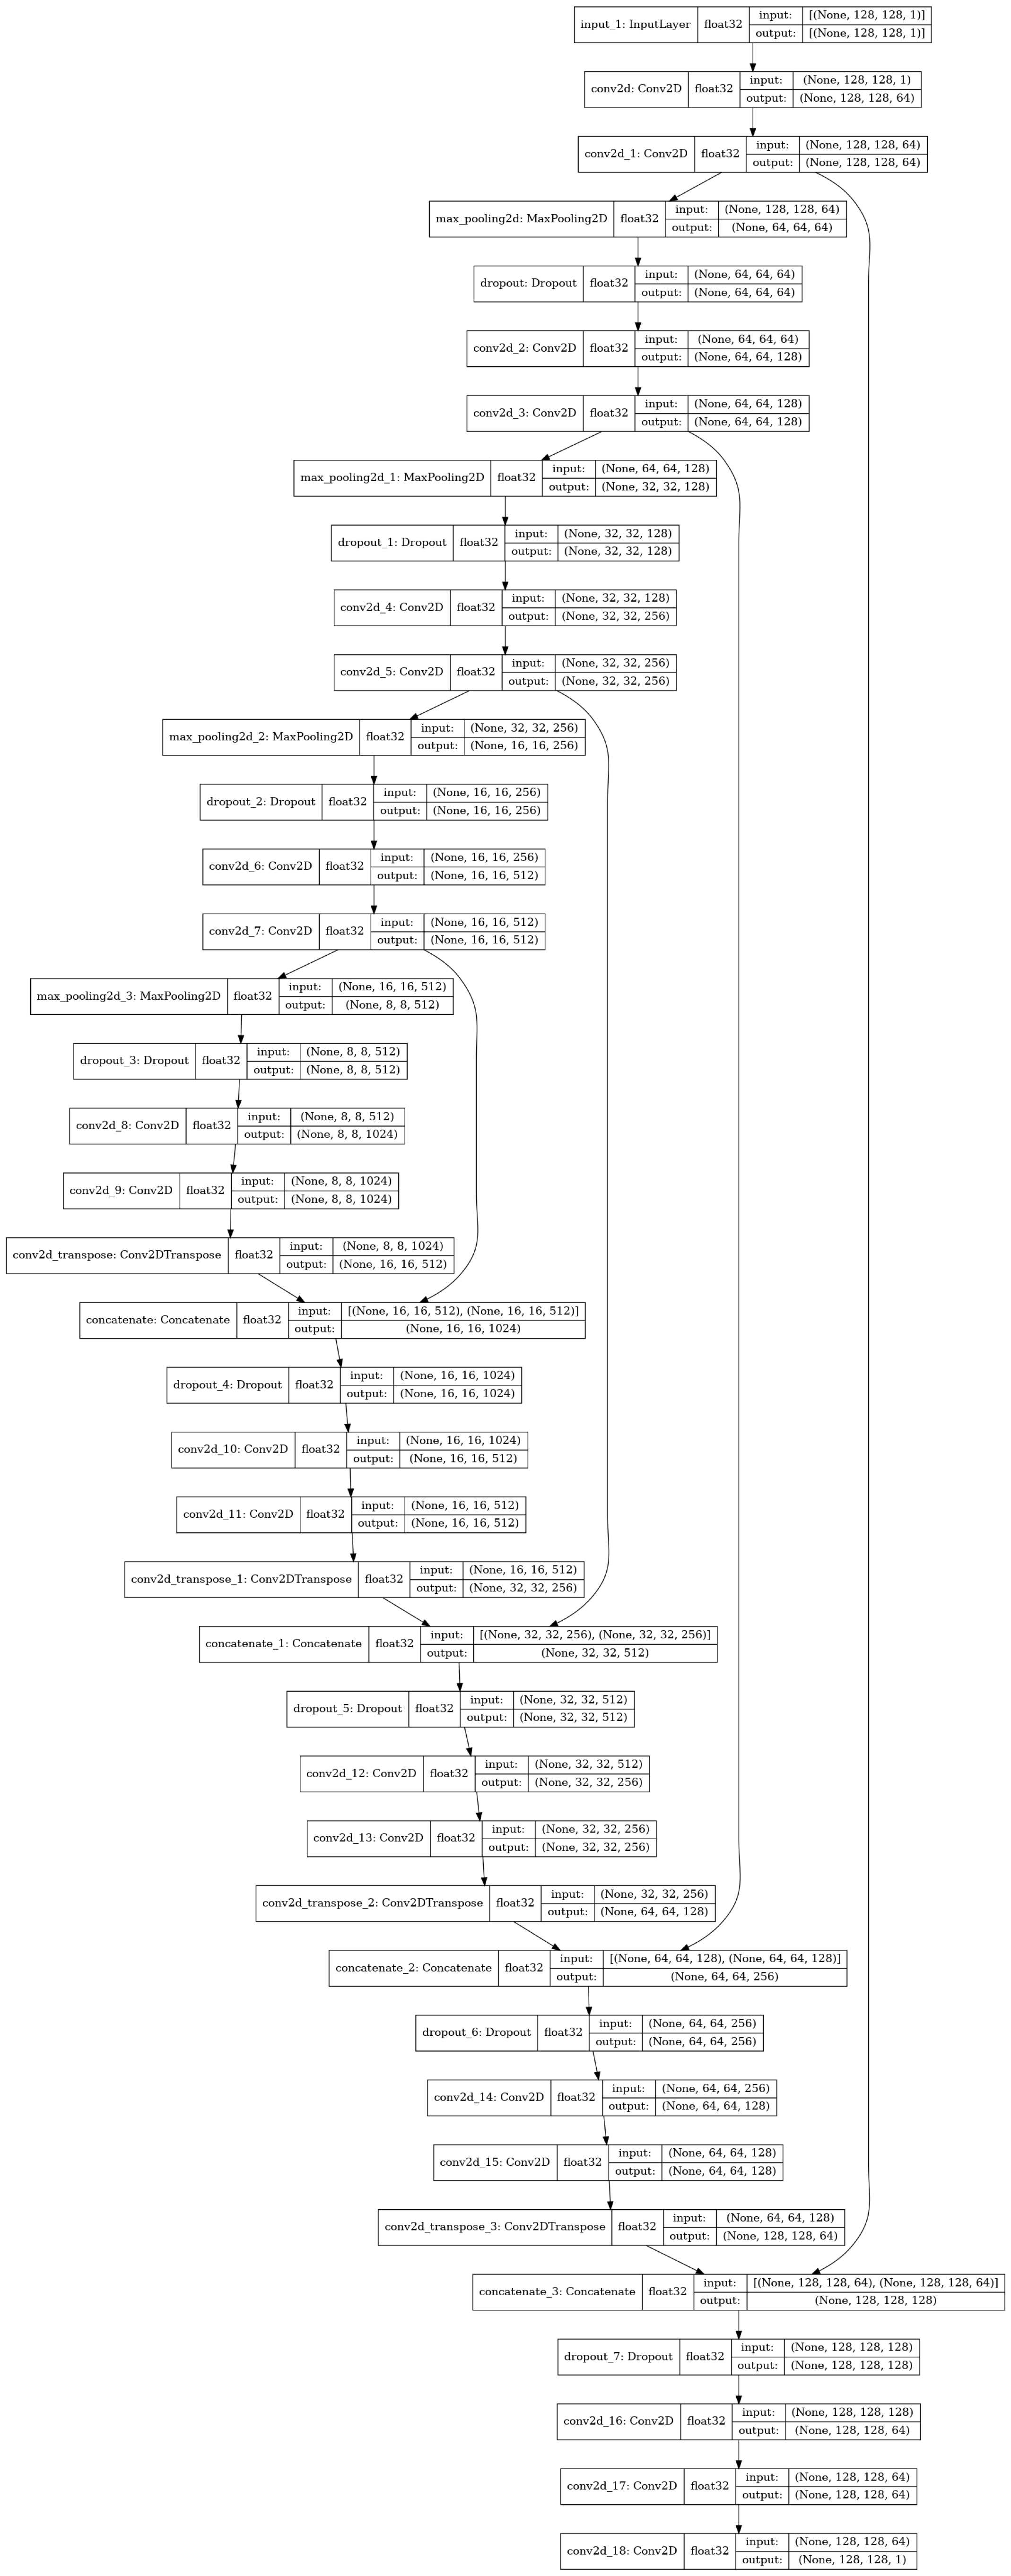

In [11]:
model_plotter(u_net)

In [12]:
images = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/image")
masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/mask")

In [13]:
v_images = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/image")
v_masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/mask")

In [14]:
print(len(images)==len(masks))
print(len(v_images)==len(v_masks))

True
True


In [15]:
masks[:10]

['cxrmask_3449.jpeg',
 'cxrmask_3820.jpeg',
 'cxrmask_9400.jpeg',
 'cxrmask_2412.jpeg',
 'cxrmask_4460.jpeg',
 'cxrmask_4158.jpeg',
 'cxrmask_10405.jpeg',
 'cxrmask_9726.jpeg',
 'cxrmask_2658.jpeg',
 'cxrmask_1604.jpeg']

In [16]:
images[:10]

['cxrimage_10391.png',
 'cxrimage_9449.png',
 'cxrimage_5100.png',
 'cxrimage_16921.png',
 'cxrimage_13933.png',
 'cxrimage_9530.png',
 'cxrimage_9345.png',
 'cxrimage_13839.png',
 'cxrimage_16019.png',
 'cxrimage_9100.png']

In [17]:
masks.sort()
images.sort()
v_masks.sort()
v_images.sort()

In [18]:
temp = 0
while temp<20:
  print(images[temp].split("_")[1].split(".")[0] == masks[temp].split("_")[1].split(".")[0])
  temp+=1

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [19]:
import random

i = random.randint(0,len(images)-1)
img = np.asarray(Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/image",images[i])))
mask = np.asarray(Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/mask",masks[i])))
print(img.shape,mask.shape)

(512, 512, 4) (512, 512, 3)


In [20]:
len(images)

16932

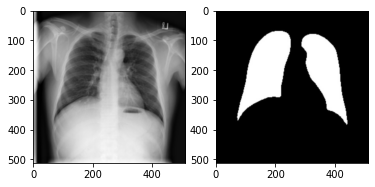

In [21]:
plt.subplot(1,2,1)
plt.imshow(img[:,:,:3]) #rgba to rgb

plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [22]:
def make_dataset(validation=False):
  x = []
  y = []
  if(validation):
    for i,(image,mask) in enumerate(zip(v_images[:10000],v_masks[:10000])):
      print("\r"+str(i)+"/"+str(len(v_images)),end="")

      image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/image",image)).convert('L')
      mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)
  else:
    for i,(image,mask) in enumerate(zip(images[:10000],masks[:10000])):
      print("\r"+str(i)+"/"+str(len(images)),end="")
      
      image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/image",image)).convert('L')
      mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)

  return np.array(x),np.array(y)


In [23]:
x,y = make_dataset()

9999/16932

In [24]:
v_x,v_y = make_dataset(True)

2116/2117

In [25]:
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow(
    x,
    batch_size=64,
    seed=seed)

mask_generator = mask_datagen.flow(
    y,
    batch_size=64,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 1

image_test_generator = image_test_datagen.flow(
    v_x,
    batch_size=64,
    seed=seed)

mask_test_generator = mask_test_datagen.flow(
    v_y,
    batch_size=64,
    seed=seed)

valid_generator = zip(image_test_generator, mask_test_generator)

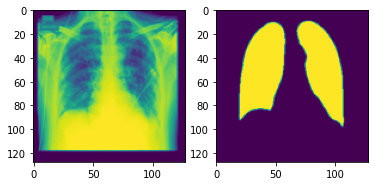

In [28]:
i = random.randint(0,len(x))

img = x[i]
mask = y[i]

plt.subplot(1,2,1)
plt.imshow(np.squeeze(img))

plt.subplot(1,2,2)
plt.imshow(np.squeeze(mask))

plt.show()

In [29]:
u_net.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [30]:
model_history = u_net.fit(train_generator,epochs=20,validation_data=valid_generator,steps_per_epoch = int(x.shape[0] / 64),validation_steps = int(v_x.shape[0] / 64))

2022-10-19 11:54:19.351864: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-19 11:54:21.752648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


156/156 [==============================] - 86s 456ms/step - loss: 0.3369 - accuracy: 0.7979 - val_loss: 0.1600 - val_accuracy: 0.9092
Epoch 2/20
156/156 [==============================] - 73s 454ms/step - loss: 0.0925 - accuracy: 0.9018 - val_loss: 0.0711 - val_accuracy: 0.9348
Epoch 3/20
156/156 [==============================] - 71s 454ms/step - loss: 0.0591 - accuracy: 0.9097 - val_loss: 0.0687 - val_accuracy: 0.9374
Epoch 4/20
156/156 [==============================] - 70s 452ms/step - loss: 0.0498 - accuracy: 0.9120 - val_loss: 0.0611 - val_accuracy: 0.9380
Epoch 5/20
156/156 [==============================] - 70s 452ms/step - loss: 0.0487 - accuracy: 0.9119 - val_loss: 0.0523 - val_accuracy: 0.9405
Epoch 6/20
156/156 [==============================] - 71s 452ms/step - loss: 0.0453 - accuracy: 0.9125 - val_loss: 0.0558 - val_accuracy: 0.9390
Epoch 7/20
156/156 [==============================] - 71s 453ms/step - loss: 0.0433 - accuracy: 0.9130 - val_loss: 0.0518 - val_accuracy: 0.9

In [31]:
u_net.save("u_net.h5")

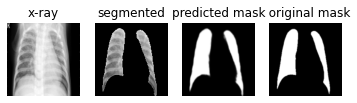

In [32]:
i = random.randint(0,len(v_x)-1)

original = v_x[i].copy()
original_mask = v_y[i].copy()

mask = u_net.predict(np.expand_dims(original,axis=0))


segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0

plt.subplot(1,4,1)
plt.imshow(np.squeeze(original),cmap="gray")
plt.title("x-ray")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(segmented,cmap="gray")
plt.title("segmented")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(mask[0]),cmap="gray")
plt.title("predicted mask")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(np.squeeze(original_mask),cmap="gray")
plt.title("  original mask")
plt.axis("off")


plt.show()